In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import numpy as np
import matplotlib.dates as mdates


In [18]:
# Load the data from the csv file, and parse the dates to datetime format
df_TAT = pd.read_excel("Vorlage_TAT_Lithium.xlsx", header=[0, 1])

# Ab der dritten Spalte die Werte in datetime konvertieren
for col in df_TAT.columns[2:]:  # Nur ab der dritten Spalte
    df_TAT[col] = pd.to_datetime(df_TAT[col], errors='coerce', dayfirst=True)  # Fehlerhafte Werte werden zu NaT


df_TAT.head()
df_TAT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   (Unnamed: 0_level_0, Auftragsnummer)        4 non-null      int64         
 1   (Unnamed: 1_level_0, Anforderung)           4 non-null      object        
 2   (Präanalytische Phase, Eingang)             4 non-null      datetime64[ns]
 3   (Analytische Phase, Messung)                4 non-null      datetime64[ns]
 4   (Postanalytische Phase, Tech. Validation)   4 non-null      datetime64[ns]
 5   (Postanalytische Phase, Validation)         4 non-null      datetime64[ns]
 6   (Postanalytische Phase, Auftragsabschluss)  4 non-null      datetime64[ns]
dtypes: datetime64[ns](5), int64(1), object(1)
memory usage: 356.0+ bytes


In [23]:
df_TAT.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Präanalytische Phase  \
      Auftragsnummer        Anforderung              Eingang   
0           21553310                 li  2024-05-15 12:45:45   
1           21554328                 li  2024-05-16 13:01:01   
2           21547858                 li  2024-05-06 12:38:54   
3           40615708                 li  2024-05-31 12:18:47   

    Analytische Phase Postanalytische Phase                      \
              Messung      Tech. Validation          Validation   
0 2024-05-15 14:46:59   2024-05-15 16:10:00 2024-05-15 17:07:01   
1 2024-05-16 14:15:22   2024-05-16 14:56:01 2024-05-16 16:00:00   
2 2024-05-06 14:13:00   2024-05-06 15:01:00 2024-05-06 15:45:00   
3 2024-05-31 13:06:10   2024-05-31 13:10:00 2024-05-31 13:41:00   

                       
    Auftragsabschluss  
0 2024-05-15 17:07:01  
1 2024-05-16 16:00:00  
2 2024-05-06 15:45:00  
3 2024-05-31 14:25:36

In [21]:
# Dictionary zur Speicherung der Phasen und ihrer Schritte
phases = {}

# Iteration über die Spalten ab der dritten
for col in df_TAT.columns[2:]:
    phase = col[0].strip()  # Übergeordnete Phase
    step = col[1].strip()   # Untergeordneter Schritt
    
    # Phase hinzufügen, falls noch nicht vorhanden
    if phase not in phases:
        phases[phase] = []
    
    # Schritt hinzufügen, falls noch nicht vorhanden
    if step not in phases[phase]:
        phases[phase].append(step)

# Ausgabe der Phasenstruktur
for phase, checkpoints in phases.items():
    print(f"{phase}:")
    for checkpoint in checkpoints:
        print(f"  - {checkpoint}")

Präanalytische Phase:
  - Eingang
Analytische Phase:
  - Messung
Postanalytische Phase:
  - Tech. Validation
  - Validation
  - Auftragsabschluss


In [24]:
# Nur die zweite Hierarchieebene behalten
df_TAT.columns = df_TAT.columns.droplevel(0)

In [25]:
# Get the keys of the phases
phase_keys = list(phases.keys())

# Iterate through the phases
for i in range(len(phase_keys)):
    current_phase = phase_keys[i]
    current_phase_checkpoints = phases[current_phase]

    last_phase = len(phase_keys) - 1 # With 3 phases, the last phase is 2

    if i < last_phase:
        # For all but the last phase, calculate the difference between the first column of the current phase and the next phase
        next_phase = phase_keys[i + 1]
        next_phase_checkpoints = phases[next_phase]

        coL_phase_start = current_phase_checkpoints[0]
        col_phase_end = next_phase_checkpoints[0]

        print(f"Calculating TAT for {current_phase}: {coL_phase_start} - {col_phase_end}")

        df_TAT[f"{current_phase}"] = df_TAT[col_phase_end] - df_TAT[coL_phase_start]

        df_TAT[f"{current_phase} in Minuten"] = df_TAT[current_phase].dt.total_seconds() / 60

    else:
        # For the last phase, calculate the difference between its first and last column

        coL_phase_start = current_phase_checkpoints[0]
        col_phase_end = current_phase_checkpoints[-1]
        
        print(f"Calculating TAT for {current_phase}: {coL_phase_start} - {col_phase_end}")

        df_TAT[f"{current_phase}"] = df_TAT[col_phase_end] - df_TAT[coL_phase_start]

        df_TAT[f"{current_phase} in Minuten"] = df_TAT[current_phase].dt.total_seconds() / 60

df_TAT


Calculating TAT for Präanalytische Phase: Eingang - Messung
Calculating TAT for Analytische Phase: Messung - Tech. Validation
Calculating TAT for Postanalytische Phase: Tech. Validation - Auftragsabschluss


,Auftragsnummer,Anforderung,Eingang,Messung,Tech. Validation,Validation,Auftragsabschluss,Präanalytische Phase,Präanalytische Phase in Minuten,Analytische Phase,Analytische Phase in Minuten,Postanalytische Phase,Postanalytische Phase in Minuten
0,21553310,li,2024-05-15 12:45:45,2024-05-15 14:46:59,2024-05-15 16:10:00,2024-05-15 17:07:01,2024-05-15 17:07:01,0 days 02:01:14,121.233333,0 days 01:23:01,83.016667,0 days 00:57:01,57.016667
1,21554328,li,2024-05-16 13:01:01,2024-05-16 14:15:22,2024-05-16 14:56:01,2024-05-16 16:00:00,2024-05-16 16:00:00,0 days 01:14:21,74.350000,0 days 00:40:39,40.650000,0 days 01:03:59,63.983333
2,21547858,li,2024-05-06 12:38:54,2024-05-06 14:13:00,2024-05-06 15:01:00,2024-05-06 15:45:00,2024-05-06 15:45:00,0 days 01:34:06,94.100000,0 days 00:48:00,48.000000,0 days 00:44:00,44.000000
3,40615708,li,2024-05-31 12:18:47,2024-05-31 13:06:10,2024-05-31 13:10:00,2024-05-31 13:41:00,2024-05-31 14:25:36,0 days 00:47:23,47.383333,0 days 00:03:50,3.833333,0 days 01:15:36,75.600000


In [26]:
# Calculate the difference between the first and last checkpoint over all phases
first_checkpoint = phases[phase_keys[0]][0]
last_checkpoint = phases[phase_keys[-1]][-1]

df_TAT['Total_TAT'] = df_TAT[last_checkpoint] - df_TAT[first_checkpoint]
df_TAT['Total_TAT in Minuten'] = df_TAT['Total_TAT'].dt.total_seconds() / 60
df_TAT[['Total_TAT', 'Total_TAT in Minuten']]

,Total_TAT,Total_TAT in Minuten
0,0 days 04:21:16,261.266667
1,0 days 02:58:59,178.983333
2,0 days 03:06:06,186.100000
3,0 days 02:06:49,126.816667


In [27]:
df_TAT.describe()

,Auftragsnummer,Eingang,Messung,Tech. Validation,Validation,Auftragsabschluss,Präanalytische Phase,Präanalytische Phase in Minuten,Analytische Phase,Analytische Phase in Minuten,Postanalytische Phase,Postanalytische Phase in Minuten,Total_TAT,Total_TAT in Minuten
count,4.000000e+00,4,4,4,4,4,4,4.000000,4,4.000000,4,4.000000,4,4.000000
mean,2.631780e+07,2024-05-17 12:41:06.750000128,2024-05-17 14:05:22.749999872,2024-05-17 14:49:15.249999872,2024-05-17 15:38:15.249999872,2024-05-17 15:49:24.249999872,0 days 01:24:16,84.266667,0 days 00:43:52.500000,43.875000,0 days 01:00:09,60.150000,0 days 03:08:17.500000,188.291667
min,2.154786e+07,2024-05-06 12:38:54,2024-05-06 14:13:00,2024-05-06 15:01:00,2024-05-06 15:45:00,2024-05-06 15:45:00,0 days 00:47:23,47.383333,0 days 00:03:50,3.833333,0 days 00:44:00,44.000000,0 days 02:06:49,126.816667
25%,2.155195e+07,2024-05-13 06:44:02.249999872,2024-05-13 08:38:29.249999872,2024-05-13 09:52:45,2024-05-13 10:46:30.750000128,2024-05-13 10:46:30.750000128,0 days 01:07:36.500000,67.608333,0 days 00:31:26.750000,31.445833,0 days 00:53:45.750000,53.762500,0 days 02:45:56.500000,165.941667
50%,2.155382e+07,2024-05-16 00:53:23,2024-05-16 02:31:10.500000,2024-05-16 03:33:00.500000,2024-05-16 04:33:30.500000,2024-05-16 04:33:30.500000,0 days 01:24:13.500000,84.225000,0 days 00:44:19.500000,44.325000,0 days 01:00:30,60.500000,0 days 03:02:32.500000,182.541667
75%,2.631967e+07,2024-05-20 06:50:27.500000,2024-05-20 07:58:04,2024-05-20 08:29:30.750000128,2024-05-20 09:25:15,2024-05-20 09:36:24,0 days 01:40:53,100.883333,0 days 00:56:45.250000,56.754167,0 days 01:06:53.250000,66.887500,0 days 03:24:53.500000,204.891667
max,4.061571e+07,2024-05-31 12:18:47,2024-05-31 13:06:10,2024-05-31 13:10:00,2024-05-31 13:41:00,2024-05-31 14:25:36,0 days 02:01:14,121.233333,0 days 01:23:01,83.016667,0 days 01:15:36,75.600000,0 days 04:21:16,261.266667
std,9.531938e+06,NaN,NaN,NaN,NaN,NaN,0 days 00:31:12.522185004,31.208703,0 days 00:32:28.174957920,32.469583,0 days 00:13:12.997267754,13.216621,0 days 00:55:21.922585893,55.365376


# Diagramme

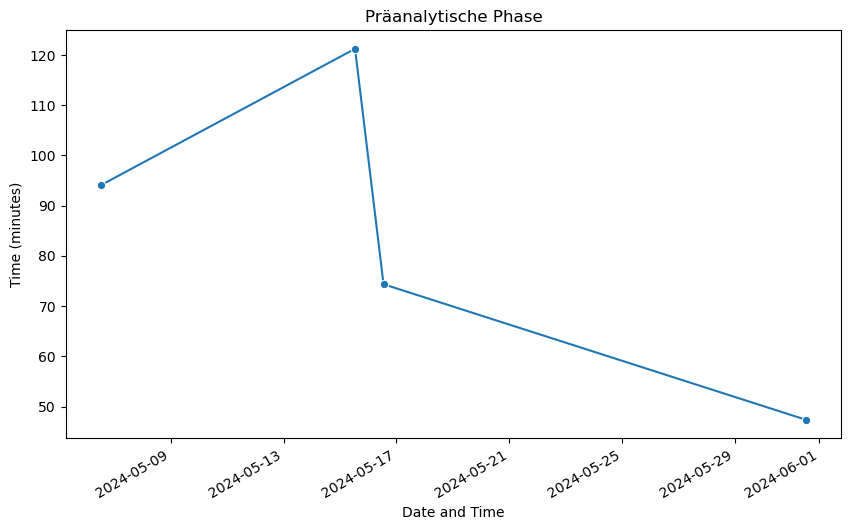

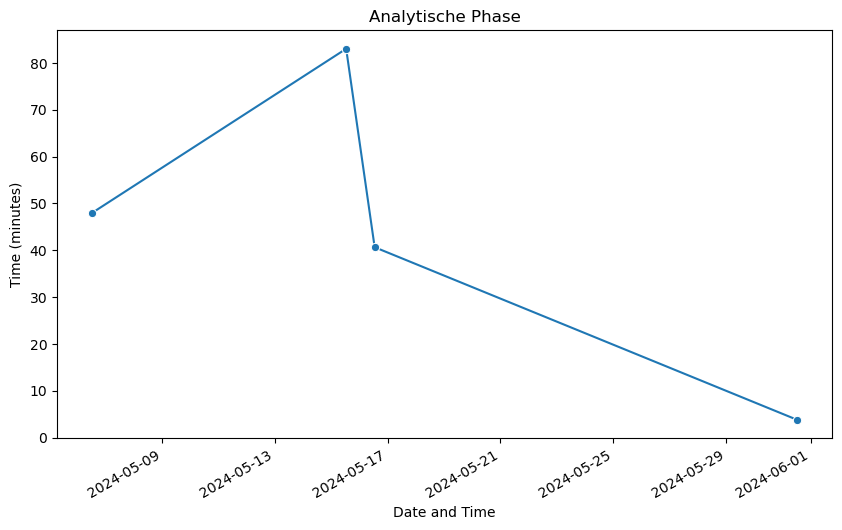

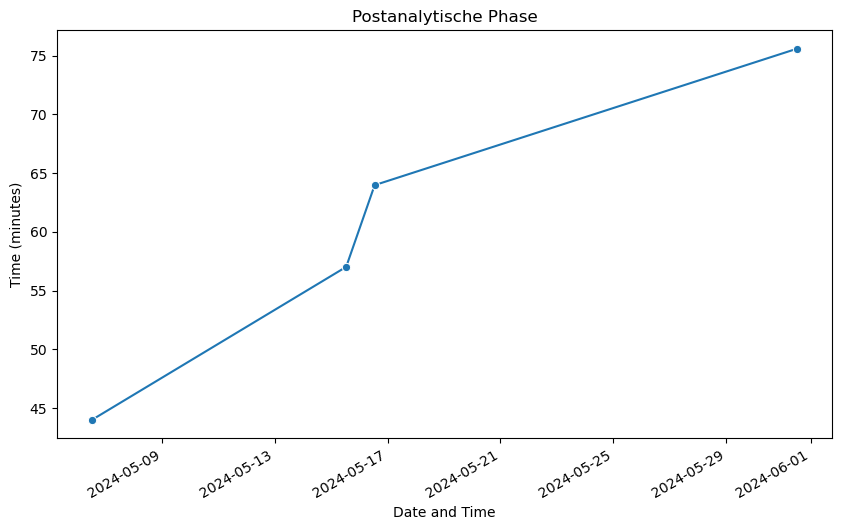

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

def plot_phase(df, phase_column, time_column='Eingang', time_format='%Y-%m-%d', title='Phase Plot'):
    """
    Dynamisches Plotten von Daten für jede Phase.
    
    Parameters:
        df (pd.DataFrame): DataFrame mit den Daten
        phase_column (str): Die Spalte, die die Phase repräsentiert (z. B. 'Präanalytische Phase in Minuten')
        time_column (str): Die Spalte, die das Datum/Zeit enthält (Standard: 'Eingang')
        time_format (str): Format für das Datum auf der x-Achse (Standard: '%Y-%m-%d')
        title (str): Titel des Diagramms
    """
    # Liniendiagramm erstellen
    fig = plt.figure(figsize=(10, 6))
    sns.lineplot(x=df[time_column], y=df[phase_column], marker='o')

    # Achsenanpassungen
    ax = plt.gca()

    # Datumsformat auf der x-Achse anpassen
    ax.xaxis.set_major_formatter(mdates.DateFormatter(time_format))

    # Wissenschaftliche Notation auf der y-Achse deaktivieren
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.get_offset_text().set_visible(False)  # Optional: Offset-Text entfernen

    # Datumswerte auf der x-Achse schön formatieren
    fig.autofmt_xdate()

    # Titel und Achsenbeschriftungen hinzufügen
    plt.title(title)
    plt.xlabel('Date and Time')
    plt.ylabel('Time (minutes)')

    # Diagramm anzeigen
    plt.show()

# Dynamisch durch das Dictionary gehen und Diagramme erstellen
for phase, steps in phases.items():
        # Name der Spalte mit Phase und Schritt
        phase_column = f"{phase} in Minuten"
        # Diagramm für jede Phase generieren
        plot_phase(df_TAT, phase_column, time_column=df_TAT.columns[2], time_format='%Y-%m-%d', title=phase)

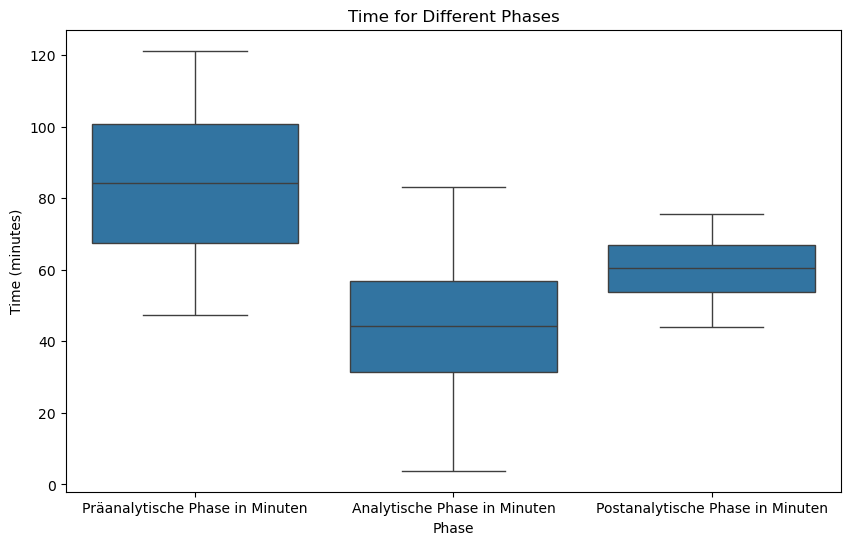

In [32]:
# Dynamisch die Zeitspalten basierend auf den Phasen-Schlüsseln auswählen
time_columns = [f"{phase} in Minuten" for phase in phases.keys()]

# Melt the DataFrame to long format for seaborn
df_melted = df_TAT.melt(id_vars=[df_TAT.columns[2]], value_vars=time_columns, var_name='Phase', value_name='Time (minutes)')

# Create a box and whiskers plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Phase', y='Time (minutes)', data=df_melted)
plt.title('Time for Different Phases')
plt.ylabel('Time (minutes)')
plt.xlabel('Phase')
plt.show()

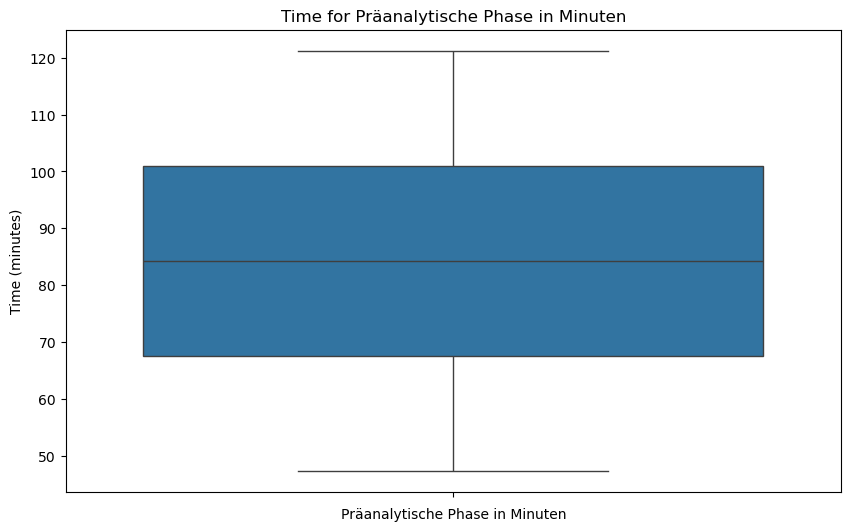

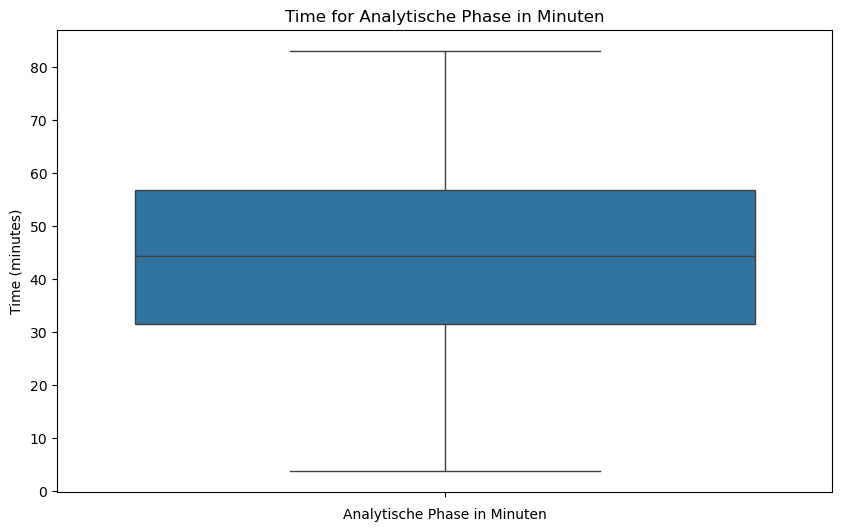

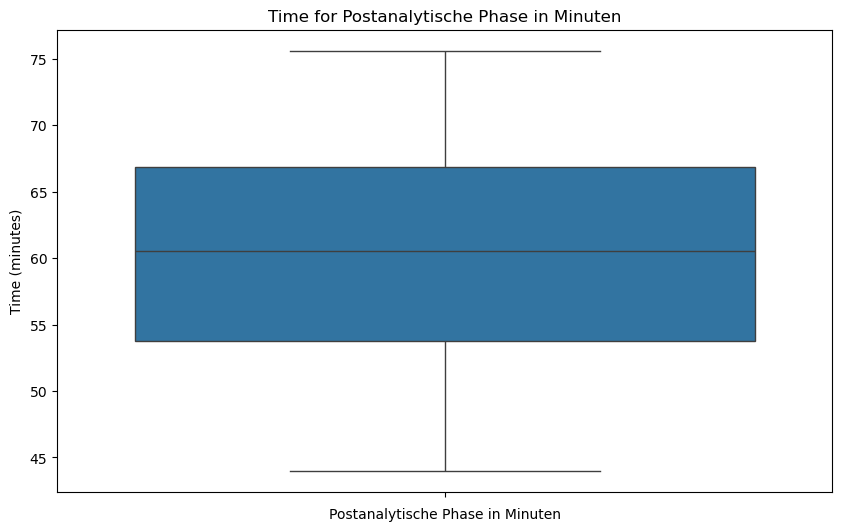

In [ ]:
# Create separate box and whiskers plots for each phase
phases = df_melted['Phase'].unique()
for phase in phases:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y='Time (minutes)', data=df_melted[df_melted['Phase'] == phase])
    plt.title(f'Time for {phase}')
    plt.ylabel('Time (minutes)')
    plt.xlabel(phase)
    plt.show()

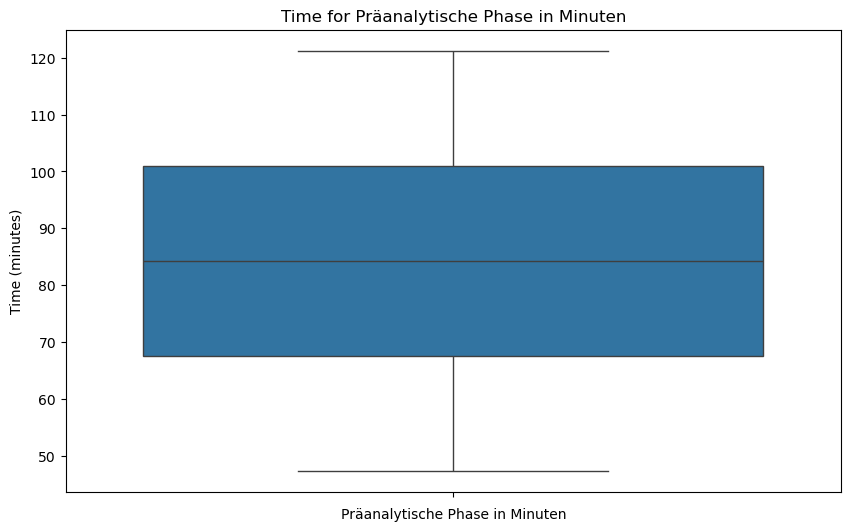

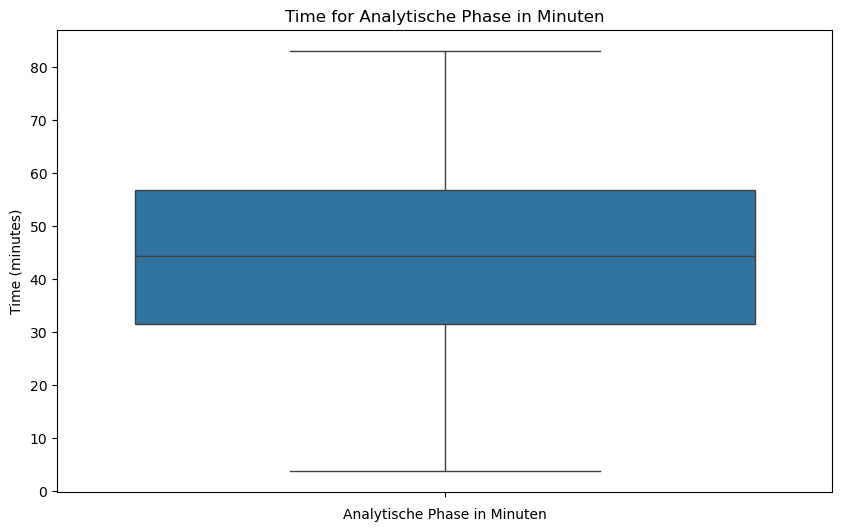

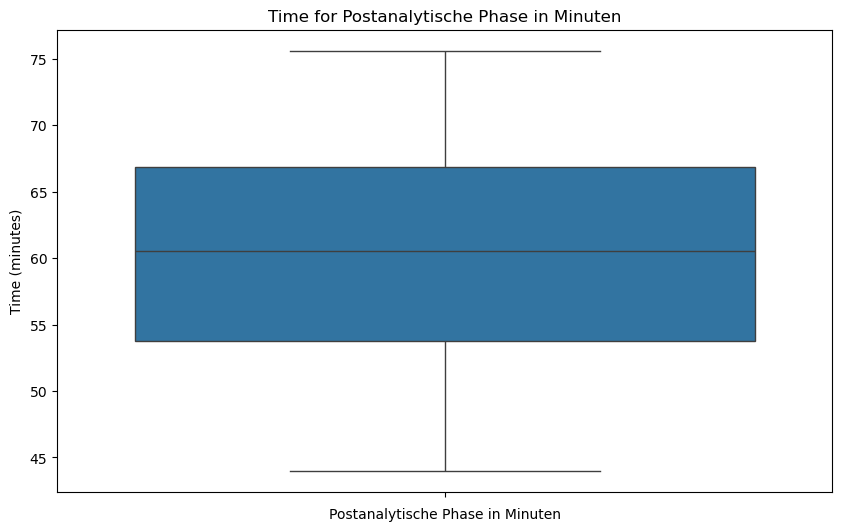

In [34]:
# Create separate box and whiskers plots for each phase without outliers
phases = df_melted['Phase'].unique()
for phase in phases:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y='Time (minutes)', data=df_melted[df_melted['Phase'] == phase], showfliers=False)
    plt.title(f'Time for {phase}')
    plt.ylabel('Time (minutes)')
    plt.xlabel(phase)
    plt.show()